Tubeの場所と予測を保存

In [231]:
import ast
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from glob import glob
from multiprocessing import Pool

In [2]:
df = pd.read_csv('/data/df_train2.csv')
df_anot = pd.read_csv('/data/train_annotations.csv')
df_bifurcation = pd.read_csv('/data/additional/RANZCR_CLiP_tracheal_bifurcation.csv')
df_cvc = pd.read_csv('/data/additional/cvc_malposition_categories.csv')

In [3]:
import math
def sigmoid(a):
    s = 1 / (1 + math.e**-a)
    return s

In [4]:
oof_800 = sigmoid(np.load('/workspace/output/exp024_test800_2/oof/oof.npy'))
oof_864 = sigmoid(np.load('/workspace/output/exp024_test864_2/oof/oof.npy'))
oof = (oof_800 + oof_864) / 2

In [5]:
df_oof = df.copy()
df_oof.loc[:, df.columns[1:12]] = oof
df_oof.head()

StudyInstanceUID  ETT - Abnormal  \
0  1.2.826.0.1.3680043.8.498.26697628953273228189...        0.001345   
1  1.2.826.0.1.3680043.8.498.46302891597398758759...        0.001430   
2  1.2.826.0.1.3680043.8.498.23819260719748494858...        0.000007   
3  1.2.826.0.1.3680043.8.498.68286643202323212801...        0.000134   
4  1.2.826.0.1.3680043.8.498.10050203009225938259...        0.000015   

   ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
0          0.003047      0.003735        0.016243          0.106178   
1          0.076165      0.936450        0.241422          0.055716   
2          0.000042      0.000059        0.000032          0.000043   
3          0.000346      0.001272        0.002425          0.001956   
4          0.000637      0.014400        0.000177          0.000206   

   NGT - Incompletely Imaged  NGT - Normal  CVC - Abnormal  CVC - Borderline  \
0                   0.009688      0.798720        0.176817          0.059686   
1                   0.776671      0.066677        0.027979          0.091682   
2                   0.000065      0.000050        0.014588          0.572776   
3                   0.000898      0.000724        0.978339          0.024767   
4                   0.000502      0.000376        0.000678          0.002632   

   CVC - Normal  Swan Ganz Catheter Present  PatientID  fold  \
0      0.062804                    0.000457  ec89415d1     3   
1      0.870807                    0.003910  bf4c6da3c     3   
2      0.412521                    0.000046  3fc1c97e5     3   
3      0.021996                    0.000234  c31019814     0   
4      0.998719                    0.000002  207685cd1     0   

                                            img_path  cv  
0  /data/train512/1.2.826.0.1.3680043.8.498.26697...   3  
1  /data/train512/1.2.826.0.1.3680043.8.498.46302...   3  
2  /data/train512/1.2.826.0.1.3680043.8.498.23819...   3  
3  /data/train512/1.2.826.0.1.3680043.8.498.68286...   0  
4  /data/train512/1.2.826.0.1.3680043.8.498.10050...   0

In [135]:
lung_path = glob('/data/additional/train_lung_masks/train_lung_masks/*jpg')

In [6]:
cvc_cols = ["CVC - Abnormal", "CVC - Borderline", "CVC - Normal"]

In [7]:
df["is_cvc"] = df[cvc_cols].max(1)

In [8]:
df["CVC - Abnormal"].value_counts()

0    26888
1     3195
Name: CVC - Abnormal, dtype: int64

In [9]:
df["CVC - Borderline"].value_counts()

0    21623
1     8460
Name: CVC - Borderline, dtype: int64

In [10]:
df["CVC - Normal"].value_counts()

1    21324
0     8759
Name: CVC - Normal, dtype: int64

In [214]:
mask = cv2.imread('/data/additional/train_lung_masks/train_lung_masks/1.2.826.0.1.3680043.8.498.10000428974990117276582711948006105617.jpg')

In [217]:
mask.max()

255

CVCの先端を自分で見つけ出すことは可能かな？

必要なところだけをピックアップ

# 手動ラベリングとか

In [218]:
def plot_xray(StudyInstanceUID, label, data):
    """
    intubation as green
    bifurcation as red
    """
    pred = df_oof[df_oof.StudyInstanceUID == StudyInstanceUID]
    Normal = pred["CVC - Normal"].values[0]
    Borderline = pred["CVC - Borderline"].values[0]
    Abnormal = pred["CVC - Abnormal"].values[0]
    
    
    img = cv2.imread('/data/train/'+StudyInstanceUID+'.jpg')
    mask = cv2.imread('/data/additional/train_lung_masks/train_lung_masks/'+StudyInstanceUID+'.jpg')
    mask = cv2.resize(mask, (1280, 1280))
    mask = (mask < 128)*255
    
    original_h, original_w, _ = img.shape
    img = cv2.resize(img, (1280, 1280))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    img = clahe.apply(img[:,:,0])
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    img[:,:,2] = img[:,:,2]*0.7+mask[:,:,2]*0.3
    
    intubation = ast.literal_eval(data)
#     intubation = ast.literal_eval(df_anot.loc[(df_anot.StudyInstanceUID==StudyInstanceUID) & (df_anot.label==label),'data'].values[0])
    for i in range(len(intubation)):
        pos_y, pos_x = intubation[i]
        pos_x = (pos_x * 1280) / original_h
        pos_y = (pos_y * 1280) / original_w
        img = cv2.circle(img, (int(pos_y), int(pos_x)), 5, (0,255,0), 5)
        img = cv2.putText(img, str(i), (int(pos_y-10), int(pos_x-10)), cv2.FONT_HERSHEY_PLAIN, fontScale=2, color=(255, 0, 0), thickness=2)
    img = cv2.circle(img, (img.shape[1]//2, img.shape[0]//2), 10, (0,0,255), 10)
    plt.figure(figsize=(12,12))
    plt.title(f'label: {label}, Normal: {Normal:.4f}, Borderline: {Borderline:.4f}, Abnormal: {Abnormal:.4f}')
    plt.imshow(img)
    
def save_xray(StudyInstanceUID, label, data, patient_id, num):
    """
    intubation as green
    bifurcation as red
    """
    pred = df_oof[df_oof.StudyInstanceUID == StudyInstanceUID]
    Normal = pred["CVC - Normal"].values[0]
    Borderline = pred["CVC - Borderline"].values[0]
    Abnormal = pred["CVC - Abnormal"].values[0]
    
    img = cv2.imread('/data/train/'+StudyInstanceUID+'.jpg')
    mask = cv2.imread('/data/additional/train_lung_masks/train_lung_masks/'+StudyInstanceUID+'.jpg')
    mask = cv2.resize(mask, (1280, 1280))
    mask = (mask < 128)*255
    
    original_h, original_w, _ = img.shape
    img = cv2.resize(img, (1280, 1280))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    img = clahe.apply(img[:,:,0])
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    img[:,:,2] = img[:,:,2]*0.7+mask[:,:,2]*0.3
    
#     intubation = ast.literal_eval(df_anot.loc[(df_anot.StudyInstanceUID==StudyInstanceUID) & (df_anot.label==label),'data'].values[0])
    intubation = ast.literal_eval(data)
    for i in range(len(intubation)):
        pos_y, pos_x = intubation[i]
        pos_x = (pos_x * 1280) / original_h
        pos_y = (pos_y * 1280) / original_w
        img = cv2.circle(img, (int(pos_y), int(pos_x)), 5, (0,255,0), 5)
        img = cv2.putText(img, str(i), (int(pos_y-10), int(pos_x-10)), cv2.FONT_HERSHEY_PLAIN, fontScale=2, color=(255, 0, 0), thickness=2)
    img = cv2.circle(img, (img.shape[1]//2, img.shape[0]//2), 10, (0,0,255), 10)
    ax = plt.figure(figsize=(12,12))
    plt.title(f'label: {label}, Normal: {Normal:.4f}, Borderline: {Borderline:.4f}, Abnormal: {Abnormal:.4f}')
    plt.imshow(img)
    plt.savefig(f"/data/eda_plot/cvc_clahe_tube/{patient_id}_{StudyInstanceUID}_{label}_{num}.jpeg")
    plt.clf()
    plt.close()
    del ax
    gc.collect()

In [219]:
df_cvc = df[df.is_cvc == 1]

In [220]:
cvc_study_id = df_cvc.StudyInstanceUID.values

In [221]:
df_anot_cvc = df_anot[df_anot.label.isin(cvc_cols)]

In [222]:
# ind = i
# row = df_anot_cvc[df_anot_cvc.StudyInstanceUID == "1.2.826.0.1.3680043.8.498.56123128911983663680403594219494298539"]
# plot_xray(row.StudyInstanceUID, row.label)

In [223]:
df_anot_cvc

StudyInstanceUID             label  \
0      1.2.826.0.1.3680043.8.498.12616281126973421762...      CVC - Normal   
1      1.2.826.0.1.3680043.8.498.12616281126973421762...      CVC - Normal   
2      1.2.826.0.1.3680043.8.498.72921907356394389969...  CVC - Borderline   
3      1.2.826.0.1.3680043.8.498.11697104485452001927...      CVC - Normal   
5      1.2.826.0.1.3680043.8.498.87704688663091069148...      CVC - Normal   
...                                                  ...               ...   
17993  1.2.826.0.1.3680043.8.498.88885675487819792225...      CVC - Normal   
17995  1.2.826.0.1.3680043.8.498.18590666552942008211...      CVC - Normal   
17996  1.2.826.0.1.3680043.8.498.66774579023475418162...      CVC - Normal   
17997  1.2.826.0.1.3680043.8.498.18560506324214035535...      CVC - Normal   
17998  1.2.826.0.1.3680043.8.498.98119637144473510638...    CVC - Abnormal   

                                                    data  
0      [[1487, 1279], [1477, 1168], [1472, 1052], [14...  
1      [[1328, 7], [1347, 101], [1383, 193], [1400, 2...  
2      [[801, 1207], [812, 1112], [823, 1023], [842, ...  
3      [[1366, 961], [1411, 861], [1453, 751], [1508,...  
5      [[906, 604], [1103, 578], [1242, 607], [1459, ...  
...                                                  ...  
17993  [[1384, 1098], [1480, 899], [1554, 774], [1630...  
17995  [[1250, 1105], [1247, 1031], [1248, 970], [126...  
17996  [[1379, 1402], [1389, 1233], [1386, 1137], [13...  
17997  [[1302, 1543], [1308, 1488], [1317, 1355], [13...  
17998  [[1144, 1022], [1162, 934], [1179, 783], [1188...  

[11629 rows x 3 columns]

In [224]:
df_anot_cvc.StudyInstanceUID.iloc[0]

'1.2.826.0.1.3680043.8.498.12616281126973421762775197134528405307'

In [225]:
df_anot_cvc.StudyInstanceUID.iloc[1]

'1.2.826.0.1.3680043.8.498.12616281126973421762775197134528405307'

In [226]:
df_anot_cvc.data.iloc[0]

'[[1487, 1279], [1477, 1168], [1472, 1052], [1464, 924], [1453, 827], [1443, 755], [1434, 640], [1404, 514], [1387, 497], [1360, 541], [1290, 617], [1228, 696], [1179, 776], [1116, 880], [1065, 963], [1031, 999]]'

In [227]:
df_anot_cvc.data.iloc[1]

'[[1328, 7], [1347, 101], [1383, 193], [1400, 267], [1411, 366], [1400, 428], [1387, 545], [1394, 640], [1400, 707], [1417, 783], [1432, 852], [1462, 953], [1457, 1006]]'

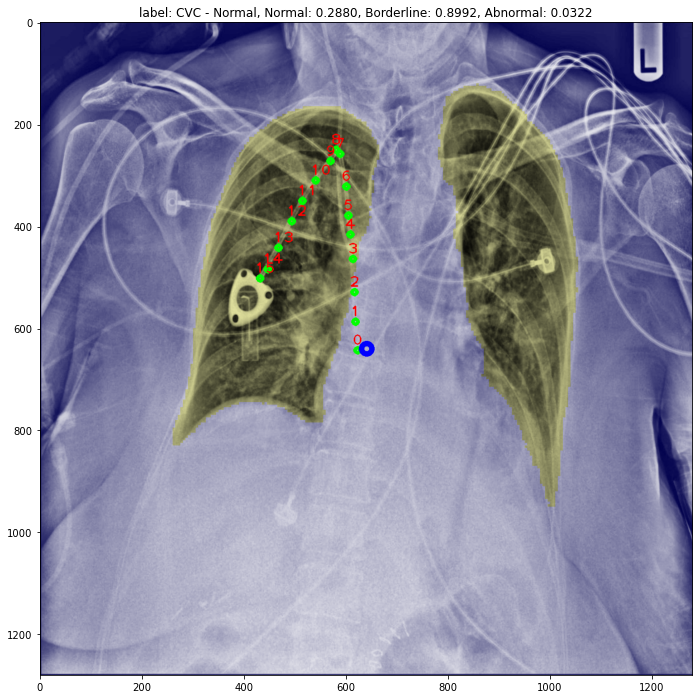

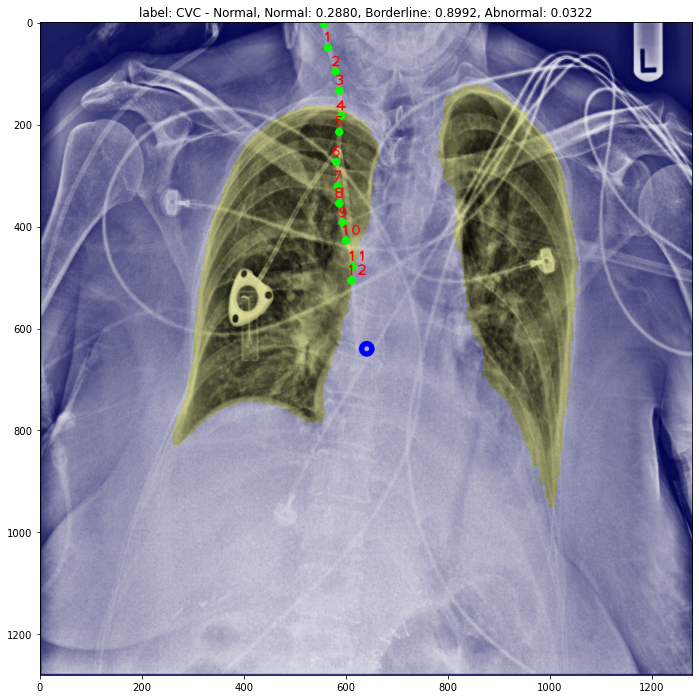

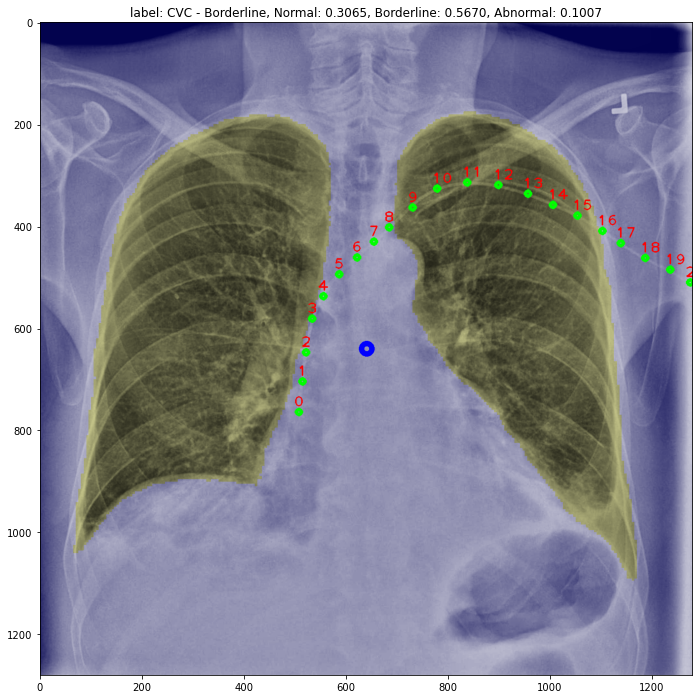

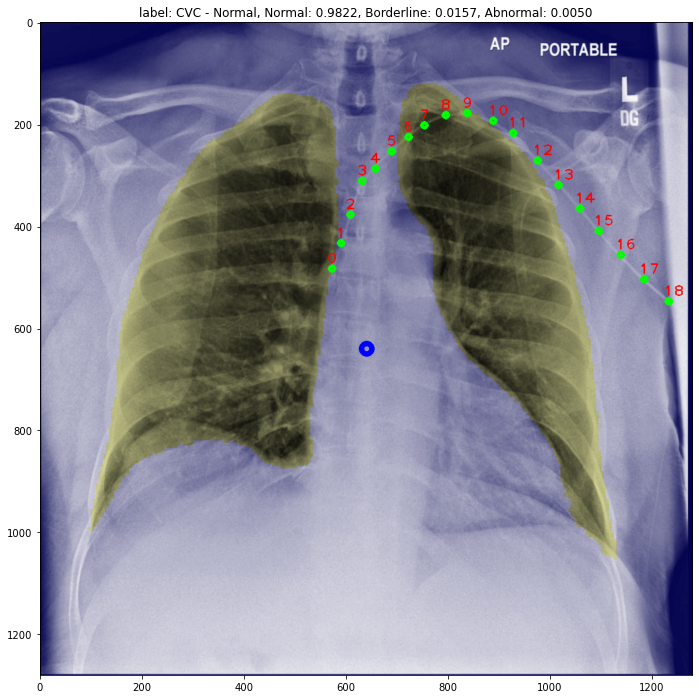

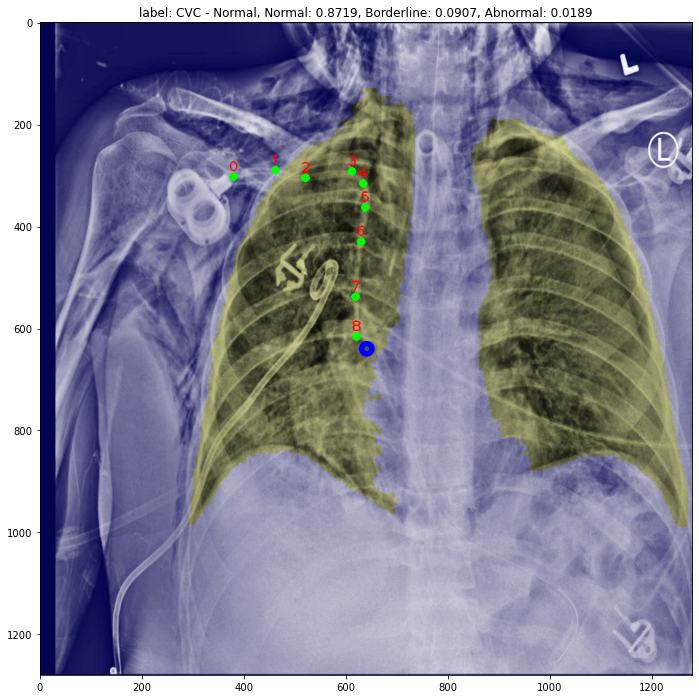

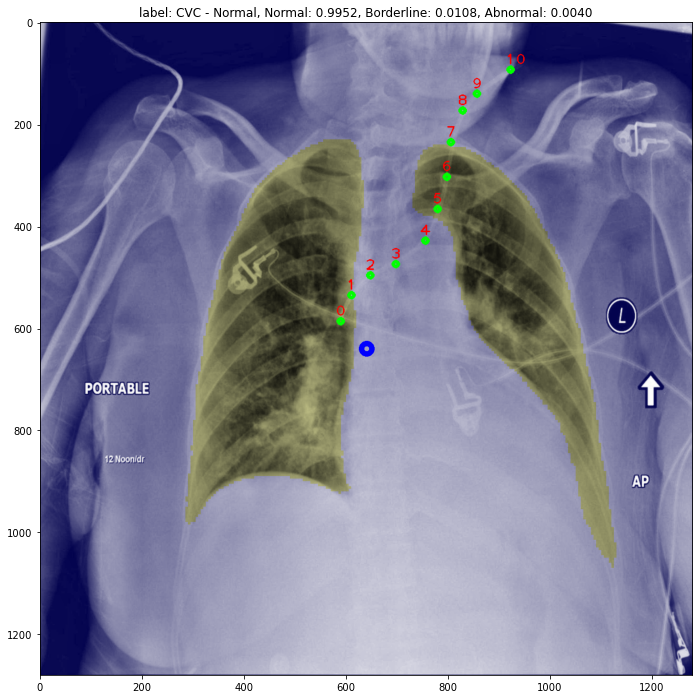

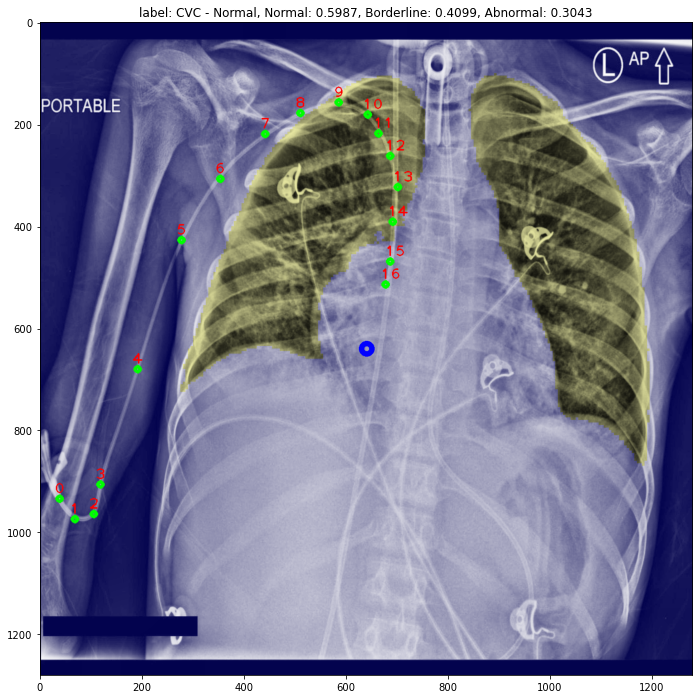

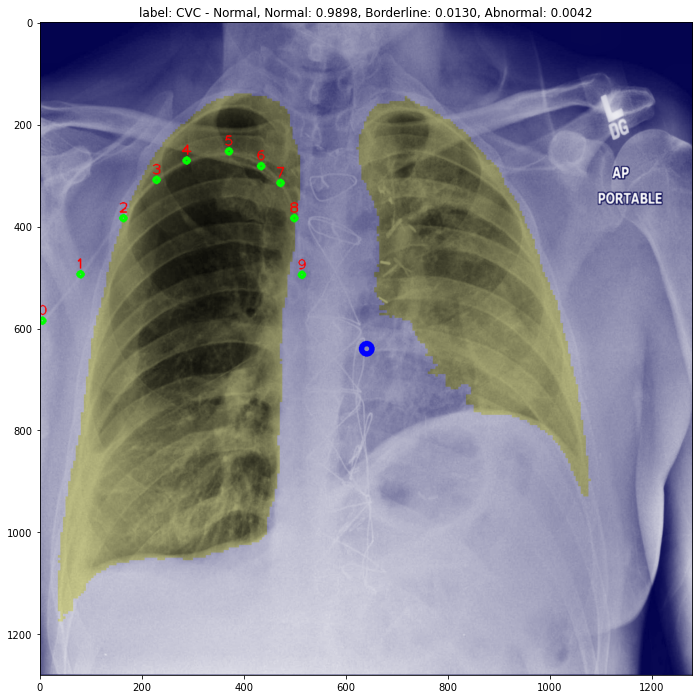

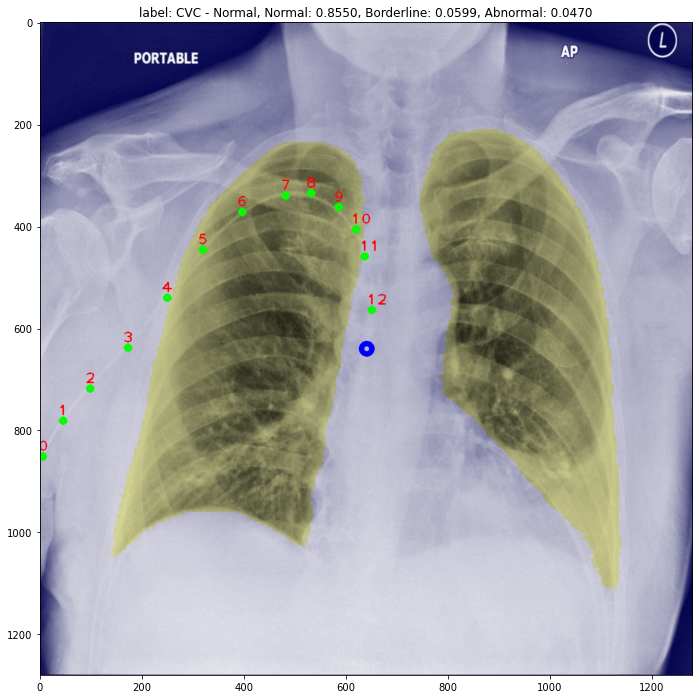

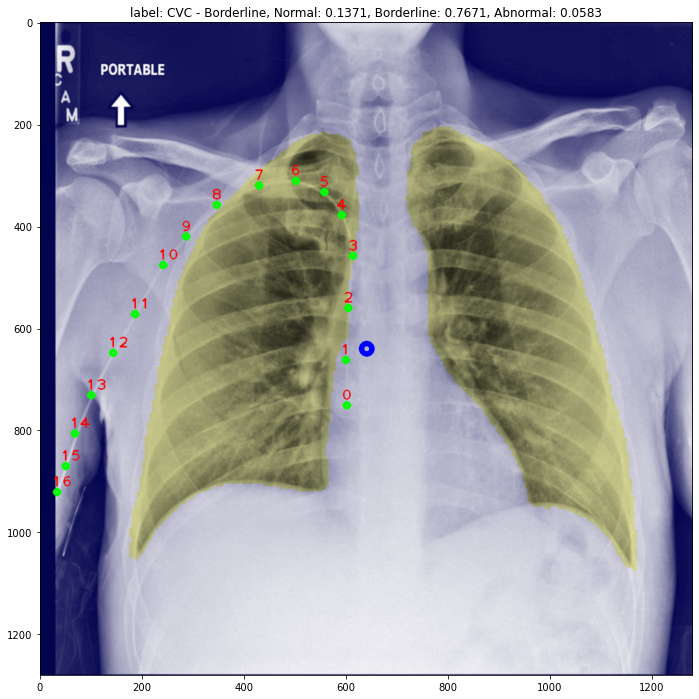

In [228]:
for i in range(10):
    ind = i
    row = df_anot_cvc.iloc[ind]
    plot_xray(row.StudyInstanceUID, row.label, row.data)

In [230]:
def save_xray_multi(ind):
    row = df_anot_cvc.iloc[ind]
    patient_id = df[df.StudyInstanceUID == row.StudyInstanceUID].PatientID.values[0]
    save_xray(row.StudyInstanceUID, row.label, row.data, patient_id, i)

In [232]:
pool = Pool(8)

In [233]:
with tqdm(total=len(df_anot_cvc)) as t:
    for _ in pool.imap_unordered(save_xray_multi, range(len(df_anot_cvc))):
        t.update(1)

100%|██████████| 11629/11629 [12:34<00:00, 15.41it/s]


In [234]:
# for i in tqdm(range(len(df_anot_cvc))):
#     ind = i
#     row = df_anot_cvc.iloc[ind]
#     patient_id = df[df.StudyInstanceUID == row.StudyInstanceUID].PatientID.values[0]
#     save_xray(row.StudyInstanceUID, row.label, row.data, patient_id, i)